In [21]:
import pandas as pd
df=pd.read_csv('winequality-red.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


### CORRELATION

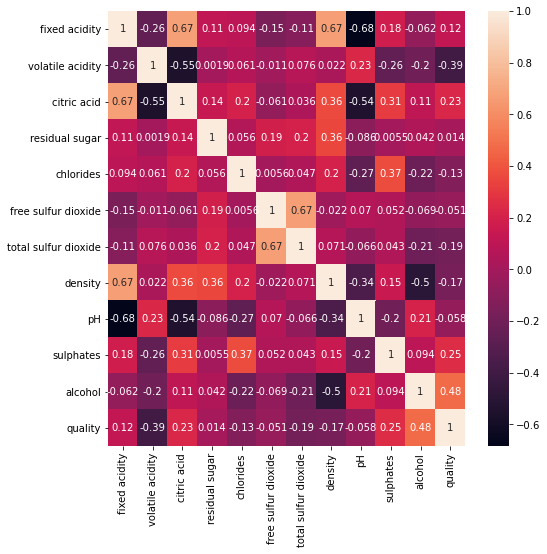

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),annot=True)

#### REMOVE DUPLICATES

In [22]:
dub_wine=df.copy()
dub_wine.drop_duplicates(subset=None,inplace=True)
dub_wine.shape
df=dub_wine

#=> there exist duplicates values since shape of original data # shape of new data after removing

#### REMOVE OUTLIERS


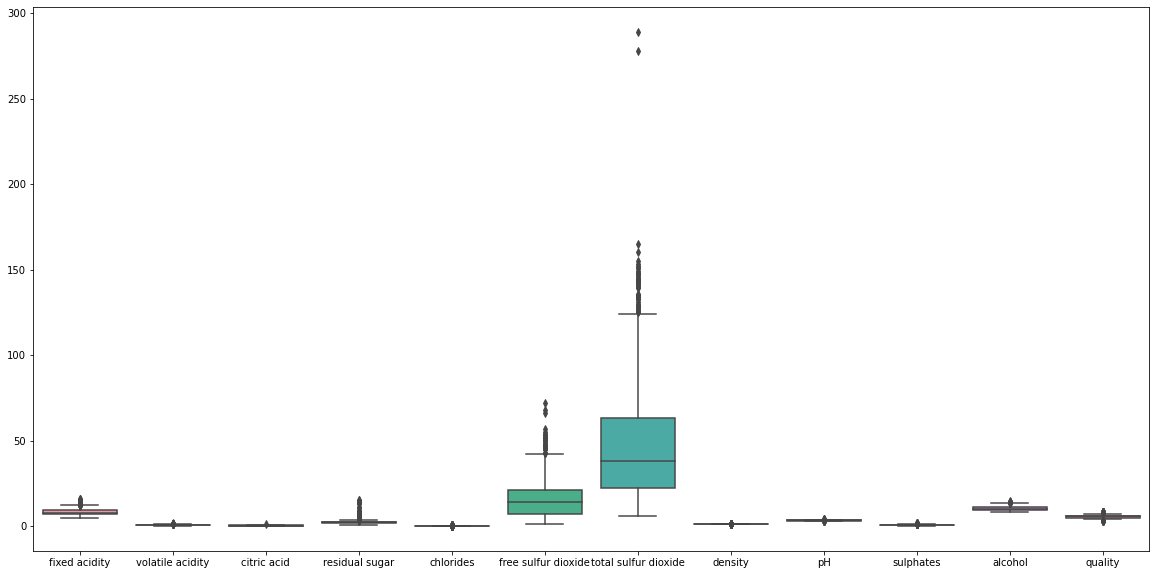

In [7]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df)

In [23]:
q1=df.quantile(0.25)
q2=df.quantile(0.75)
IQR=q2-q1
df=df[~((df<(q1-1.5*IQR))|(df>(q2+1.5*IQR))).any(axis=1)]

In [24]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler


### Encoding

In [25]:
def cat(x):
    if x>6:
        return 'good'
    else:
        return 'poor'

In [26]:
a=df['quality'].copy()
df['rating']=a.apply(lambda x: cat(x))
x=df.drop(labels=['quality','rating'],axis=1)
y=df['rating']


<ipython-input-26-f1915fb7c099>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating']=a.apply(lambda x: cat(x))


In [27]:
from sklearn.preprocessing import LabelEncoder
encode=LabelEncoder()
y_encode=encode.fit_transform(y)
y=pd.DataFrame(y_encode)

### DATA SPLITING

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x, y_encode, train_size=0.7, test_size=0.3,random_state=0)

### SCALING

In [29]:
scaler = StandardScaler()
X_train_stand = scaler.fit_transform(X_train)
X_test_stand = scaler.fit_transform(X_test)


In [30]:
cols = ['fixed acidity','volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']
X_train=pd.DataFrame(data=X_train_stand,columns=cols)
X_test=pd.DataFrame(data=X_test_stand,columns=cols)


### LOGISTIC MODEL

In [31]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression(random_state=0).fit(X_train, y_train)
preds=lm.predict(X_test)


### COFFICIENTS

In [32]:
lm.intercept_,lm.coef_

(array([3.12030346]),
 array([[-0.43744645,  0.56083211,  0.35644494, -0.00473819, -0.17670257,
          0.16318287,  0.53572218,  0.43969602,  0.10586528, -0.86360352,
         -0.82544712]]))

### MAE, MSE, RMSE, R-sq

In [33]:
print('MAE:', metrics.mean_absolute_error(y_test, preds))
print('MSE:', metrics.mean_squared_error(y_test, preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, preds)))
print('R squared: ',lm.score(X_train,y_train))


MAE: 0.08940397350993377
MSE: 0.08940397350993377
RMSE: 0.29900497238329293
R squared:  0.9004267425320057


### CHECKING VIF

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif
# 5=<vif<=10 is in safe range

,Features,VIF
0,fixed acidity,7.37
7,density,6.83
10,alcohol,3.76
8,pH,3.20
2,citric acid,2.93
6,total sulfur dioxide,2.10
1,volatile acidity,1.87
5,free sulfur dioxide,1.79
3,residual sugar,1.75
4,chlorides,1.33
